# ***Scandinavian News Articles***

This notebook is a part of the final project in *Computational Tools for data science 02807*

### ***Imports***

In [93]:
import pandas as pd 
from IPython.display import display, HTML

### ***Import Dataset***

The datasets have been scraped using ..

In [94]:
news_articles = pd.read_csv('data/articles.csv')

# information about the dataset
news_articles.head(10)
news_articles.shape[0]
news_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             1192 non-null   object
 1   headline         1192 non-null   object
 2   content          1192 non-null   object
 3   url              1192 non-null   object
 4   source           1192 non-null   object
 5   country          1192 non-null   object
 6   worldview_score  1192 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 65.3+ KB


### ***Preprocessing Steps***

#### 1. Remove irrelevant links

In some norwegian articles posted by "vg.no" there are links to another website called "e24.no". These are not relevant for the project, and are therefore dropped from the data frame

In [95]:
# drop all norwegian articles from "vg" that contains "e24" in the url
e24_links = news_articles[(news_articles['country'] == 'norway') & (news_articles['source'] == 'vg') & (news_articles['url'].str.contains('https://e24.no'))]
news_articles = news_articles.drop(e24_links.index)
news_articles.reset_index(drop=True, inplace=True)

# print number of articles after preprocessing
print("Number of articles after preprocessing:", news_articles.shape[0])

news_articles.head(10)


Number of articles after preprocessing: 1184


,date,headline,content,url,source,country,worldview_score
0,2024-04-10,Skakande orden i rätten: ”Rann blod i mina ögon”,Under 30 minuter misshandlade de tre män och h...,https://www.aftonbladet.se/nyheter/a/OoLd3k/na...,Aftonbladet,sweden,3
1,2021-03-30,Trumps vändning: Blir inga matkuponger,Det blir inga utbetalningar av matkuponger för...,https://www.aftonbladet.se/nyheter/a/GyvQb9/tr...,Aftonbladet,sweden,3
2,2021-01-27,Skakande orden i rätten: ”Rann blod i mina ögon”,/ Under 30 minuter misshandlade de tre män och...,https://www.aftonbladet.se/nyheter/a/OoLd3k/na...,Aftonbladet,sweden,3
3,2025-09-23,"Trump drømmer om fredspris, men siden torsdag ...","Trump har både harceleret mod ""Forever Wars"" o...",https://www.dr.dk/nyheder/udland/trump-droemme...,DR,denmark,3
4,2024-07-05,Kina forbyder influencere at dele sundhedstips...,Intentionen med loven er at forhindre sprednin...,https://www.dr.dk/nyheder/udland/kina-forbyder...,DR,denmark,3
5,2024-03-11,Voksne mænds begær af teenage-piger var helt i...,I 90erne optrådte en 17-årig Britney Spears i ...,https://www.berlingske.dk/eksistens/voksne-mae...,Berlingske,denmark,3
6,2023-09-27,Imamer mægler i voldssager og saboterer politi...,Alvorlige voldssager i Aarhus’ udsatte boligom...,https://www.berlingske.dk/indland/imamer-maegl...,Berlingske,denmark,3
7,2022-06-29,'Red jøderne fra den promiskuøse hær': Titusin...,Flere hundrede demonstranter røg i karambolage...,https://www.dr.dk/nyheder/udland/red-joederne-...,DR,denmark,3
8,2022-04-10,Trump truer med militæraktion i Nigeria,Trump beskylder Nigerias regering for ikke at ...,https://www.dr.dk/nyheder/udland/trump-truer-m...,DR,denmark,3
9,2021-11-08,Her er indvandringen løbet løbsk. Saint-Denis ...,"Engang var det her, franskmændene begravede de...",https://www.berlingske.dk/internationalt/her-e...,Berlingske,denmark,3


#### 2. Remove invalid source

During scraping the source "news" has been included, which is not a valid source. Rows with this source has also been dropped. 

In [96]:
# count rows with source "news"
invalid_source = news_articles[news_articles['source'] == 'news']
print("Number of articles with source 'news':", invalid_source.shape[0])

# drop rows with source "news"
news_articles = news_articles[news_articles['source'] != 'news']
news_articles.reset_index(drop=True, inplace=True)
print("Number of articles after dropping 'news' source:", news_articles.shape[0])

Number of articles with source 'news': 9
Number of articles after dropping 'news' source: 1175


#### 3. Standardize source names

Some sources have uppercase letters and some not, so we standardize by only using lowercase.

In [97]:
news_articles['source'] = news_articles['source'].str.lower()

#### 4. Remove articles outside the intended time period 2020-2025

In [98]:
news_articles['date'] = pd.to_datetime(news_articles['date'], errors='coerce')
news_articles = news_articles[(news_articles['date'] >= '2020-01-01') & (news_articles['date'] <= '2025-12-31')]
news_articles.reset_index(drop=True, inplace=True)
print("Number of articles after removing those outside 2020-2025:", news_articles.shape[0])

Number of articles after removing those outside 2020-2025: 1172


### ***Dataset Exploration***

#### Source information

The table below presents information about the sources we have retrieved. 

In [ ]:
unique_sources = news_articles[['country', 'source']].drop_duplicates().sort_values(by='country')

sources_per_country = unique_sources['country'].value_counts()
display(HTML("<h4 style='font-weight:700'>Number of Sources per Country:</h4>"))
display(HTML("<pre style='font-family:monospace'>{}</pre>".format(
    sources_per_country.rename(index=lambda s: s.capitalize()).to_string(header=False)
)))

src_counts = (news_articles
              .groupby(['country', 'source'])
              .size()
              .reset_index(name='n_articles'))

# compute average worldview_score per country and source
temp_view = news_articles.copy()
temp_view['worldview_num'] = pd.to_numeric(temp_view['worldview_score'], errors='coerce')
avg_world = temp_view.groupby(['country', 'source'])['worldview_num'].mean().reset_index(name='avg_worldview').round(2)
display_df = src_counts.merge(avg_world, on=['country', 'source'], how='left')

# add column showing the time range of articles per country and source
time_ranges = (news_articles
                .groupby(['country', 'source'])
                .agg(first_article=('date', 'min'), last_article=('date', 'max'))
                .reset_index())

time_ranges['time_range'] = (
    time_ranges['first_article'].dt.strftime('%Y-%m-%d') +
    ' to ' +
    time_ranges['last_article'].dt.strftime('%Y-%m-%d')
)

display_df = display_df.merge(time_ranges[['country', 'source', 'time_range']], on=['country', 'source'])  
display_df = display_df[['source', 'n_articles', 'avg_worldview', 'country', 'time_range']]
display_df = display_df.sort_values(by='country').copy()
display(HTML(display_df.to_html(index=False, border=0)))


source,n_articles,avg_worldview,country,time_range
berlingske,163,3.76,denmark,2020-11-11 to 2025-10-29
dr,231,3.42,denmark,2020-11-15 to 2025-10-23
information,59,4.07,denmark,2020-12-04 to 2025-10-24
jyllands-posten,231,4.16,denmark,2020-11-17 to 2025-10-10
politiken,2,3.00,denmark,2021-12-02 to 2024-02-18
aftenposten,3,4.00,norway,2021-04-30 to 2024-08-24
dagbladet,3,4.67,norway,2020-11-08 to 2025-01-29
nrk,77,4.44,norway,2020-11-14 to 2025-10-04
vg,94,4.46,norway,2020-12-10 to 2025-11-05
aftonbladet,64,4.36,sweden,2020-11-25 to 2025-10-23


#### Article Distribution

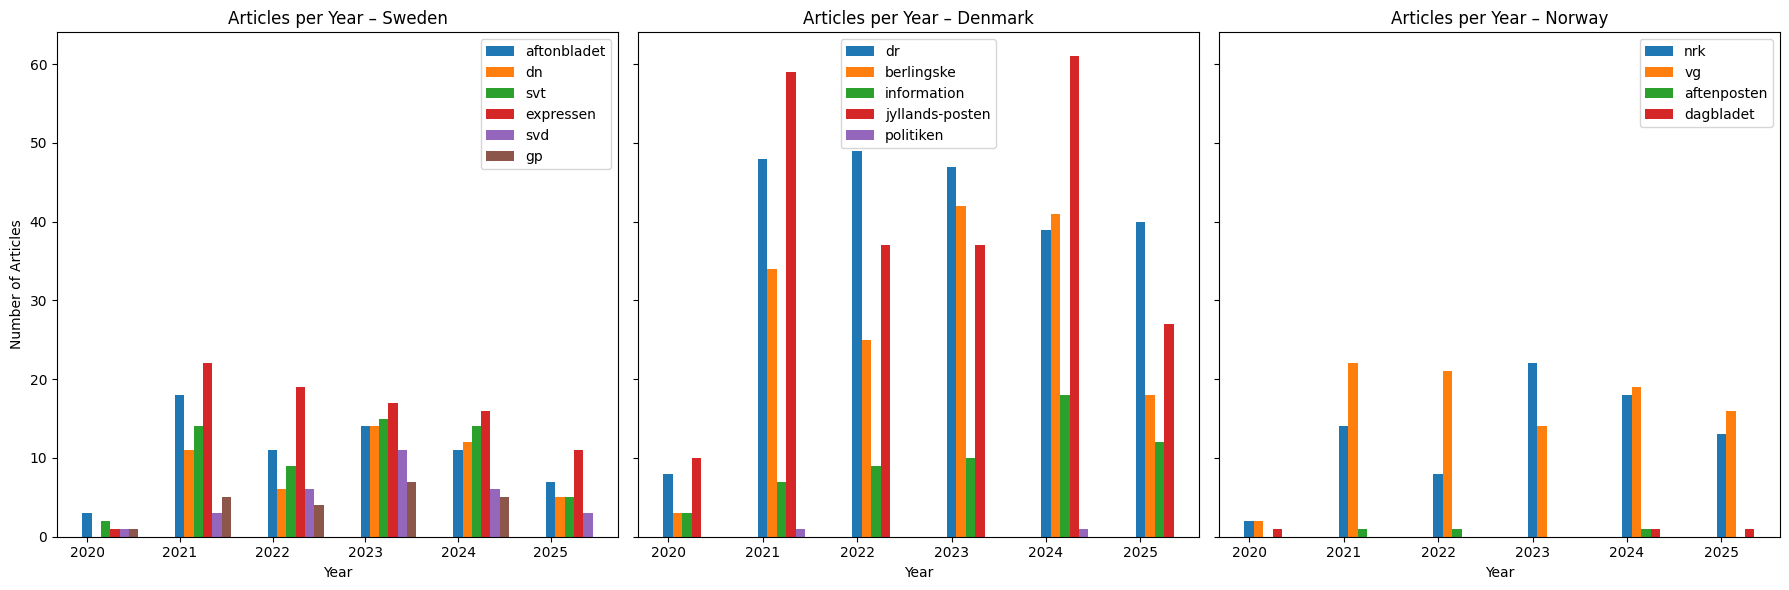

In [ ]:
import matplotlib.pyplot as plt

countries = news_articles['country'].unique()
num_countries = len(countries)

fig, axes = plt.subplots(1, num_countries, figsize=(18, 6), sharey=True)

if num_countries == 1:
    axes = [axes]

for ax, country in zip(axes, countries):
    country_data = news_articles[news_articles['country'] == country].copy()

    for i, source in enumerate(country_data['source'].unique()):
        source_data = country_data[country_data['source'] == source].copy()
        source_data['year'] = source_data['date'].dt.year
        year_counts = source_data['year'].value_counts().sort_index()

        ax.bar(
            year_counts.index + (0.1 * i),
            year_counts.values,
            width=0.1,
            label=source
        )

    ax.set_title(f'Articles per Year – {country.capitalize()}')
    ax.set_xlabel('Year')
    ax.set_xticks(range(2020, 2026))
    ax.legend()

axes[0].set_ylabel('Number of Articles')

plt.tight_layout()
plt.show()


#### Average Worldview in each Country from 2020-2025

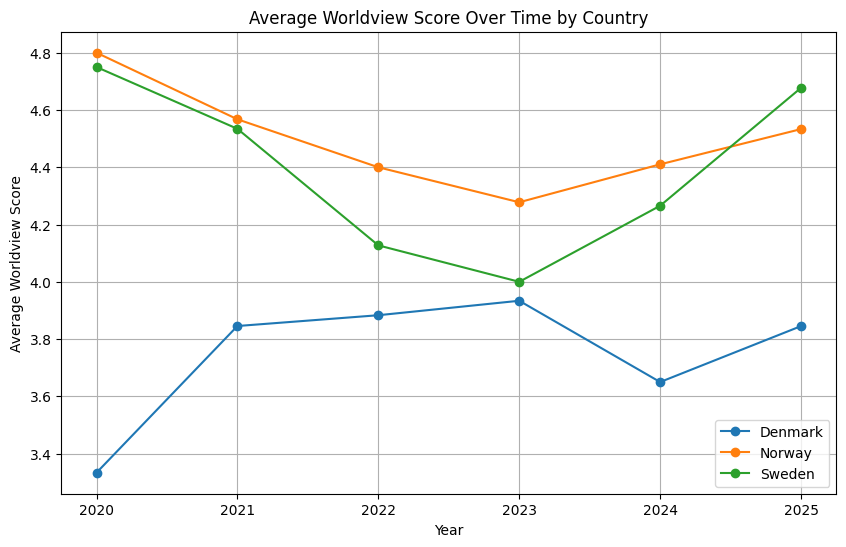

In [116]:
import matplotlib.pyplot as plt
worldview_over_time = (news_articles
                       .copy())
worldview_over_time['worldview_num'] = pd.to_numeric(worldview_over_time['worldview_score'], errors='coerce')
worldview_over_time['year'] = worldview_over_time['date'].dt.year
avg_worldview_time = (worldview_over_time
                      .groupby(['country', 'year'])['worldview_num']
                      .mean()
                      .reset_index())

plt.figure(figsize=(10, 6))
for country in avg_worldview_time['country'].unique():
    country_data = avg_worldview_time[avg_worldview_time['country'] == country]
    plt.plot(country_data['year'], country_data['worldview_num'], marker='o', label=country.capitalize())

    
plt.title('Average Worldview Score Over Time by Country')
plt.xlabel('Year')
plt.ylabel('Average Worldview Score')
plt.xticks(avg_worldview_time['year'].unique())
plt.legend()
plt.grid()
plt.show()